In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('karpathy/makemore/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
#建立映射

In [8]:
#build the dataset

block_size = 3 #context length: how many characters do we take to predict the next one
X,Y = [],[]  #x:INPUTS;y:LABLES
for w in words[:5]:
    print(w)
    context = [0]*block_size  #初始化一个长度为block_size的全零列表作为初始上下文
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]  #crop and append
        #这行代码更新上下文：它去掉最旧的字符（即列表的第一个元素）并添加当前字符的新索引。这使得上下文始终包含最新的3个字符。
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [9]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [162]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [10]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [11]:
C = torch.randn((27,2))

In [13]:
C

tensor([[-0.3677, -0.5266],
        [-0.1383,  0.3885],
        [ 0.5977,  1.4086],
        [-1.2877, -0.5404],
        [-0.5583,  0.2404],
        [-0.3566, -0.4755],
        [ 0.0512, -1.5590],
        [-0.9190, -0.3630],
        [-0.3558,  1.2853],
        [ 0.6355, -0.1595],
        [ 2.5488, -0.0401],
        [ 0.9799,  1.8392],
        [-1.1929,  2.4961],
        [-0.9382,  0.2738],
        [ 0.1845, -0.5209],
        [ 0.2685,  2.2692],
        [ 0.4356, -0.3778],
        [ 0.7269, -2.0440],
        [-0.0207, -1.8088],
        [-0.2084,  0.9846],
        [-1.1529,  1.1532],
        [-0.7714,  1.7447],
        [ 1.1283, -0.0508],
        [ 0.3044,  0.5911],
        [ 0.2873, -0.3771],
        [-0.7657, -0.2061],
        [-0.3297, -1.0171]])

In [14]:
C[5]

tensor([-0.3566, -0.4755])

In [17]:
print(C[[2,5,6]]) ## 用于index torch.tensor的方法有很多这里还可以使用torh.tensor本身
print(C[torch.tensor([5,6,7,7,7,7])])

tensor([[ 0.5977,  1.4086],
        [-0.3566, -0.4755],
        [ 0.0512, -1.5590]])
tensor([[-0.3566, -0.4755],
        [ 0.0512, -1.5590],
        [-0.9190, -0.3630],
        [-0.9190, -0.3630],
        [-0.9190, -0.3630],
        [-0.9190, -0.3630]])


In [166]:
F.one_hot(torch.tensor(5),num_classes = 27).float() @ C
#将整数 5 转换为一个长度为 27 的独热编码向量，其中第 5 位的值为 1，其余位为 0

tensor([-0.0611,  1.4440])

In [167]:
C[torch.tensor([5,6,7,7,7,7])] #从张量 C 中提取指定索引位置的元素

tensor([[-0.0611,  1.4440],
        [ 2.8922, -1.1533],
        [ 0.8891, -0.4960],
        [ 0.8891, -0.4960],
        [ 0.8891, -0.4960],
        [ 0.8891, -0.4960]])

In [19]:
#"embedding"通常指的是将高维数据映射到低维空间的过程
emb = C[X]
emb

'''C[X].shape 的意思是从张量 C 中根据索引 X 选择元素，并返回选择后的张量的形状。

在这个上下文中：

C 是一个形状为 (27, 2) 的张量，表示有 27 个特征，每个特征有 2 个值（可以视为对每个字符的嵌入向量）。
X 是一个形状为 (32, 3) 的张量，表示 32 个样本，每个样本有 3 个上下文字符的索引。
当你执行 C[X] 时：

X 中的每个值都用作 C 的行索引，提取 C 中相应的嵌入向量。
结果将是一个新张量，其中包含从 C 中提取的嵌入向量，形状将取决于 X 的形状和 C 的维度。
具体来说，C[X] 的形状将是 (32, 3, 2)，因为从 X 中提取了 32 个样本，每个样本有 3 个上下文字符，对应的每个字符有 2 个特征值（来自 C 的嵌入向量）。'''

'C[X].shape 的意思是从张量 C 中根据索引 X 选择元素，并返回选择后的张量的形状。\n\n在这个上下文中：\n\nC 是一个形状为 (27, 2) 的张量，表示有 27 个特征，每个特征有 2 个值（可以视为对每个字符的嵌入向量）。\nX 是一个形状为 (32, 3) 的张量，表示 32 个样本，每个样本有 3 个上下文字符的索引。\n当你执行 C[X] 时：\n\nX 中的每个值都用作 C 的行索引，提取 C 中相应的嵌入向量。\n结果将是一个新张量，其中包含从 C 中提取的嵌入向量，形状将取决于 X 的形状和 C 的维度。\n具体来说，C[X] 的形状将是 (32, 3, 2)，因为从 X 中提取了 32 个样本，每个样本有 3 个上下文字符，对应的每个字符有 2 个特征值（来自 C 的嵌入向量）。'

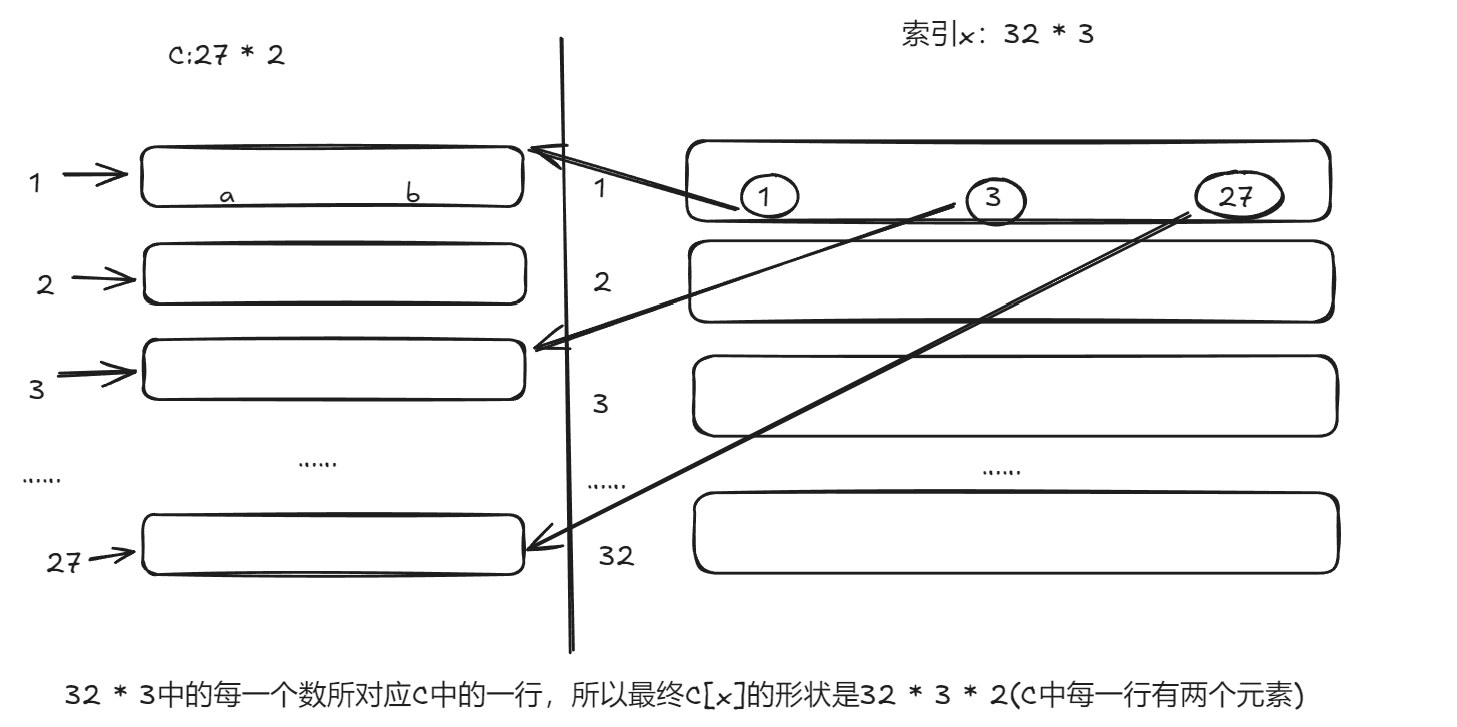

In [20]:
W1 = torch.randn((6,100))
#隐藏层：首先因为上面的形状是32 * 3 * 2 所以每一个神经元输入的应该是 3 * 2 = 6 的输入
#然后我们随机设置隐藏层神经元的数量这里是100个
b1 = torch.randn(100)


#所以这里的问题就变成了：如何将32 * 3 * 2的矩阵转化成32 * 6 的矩阵以便于实现 emb @ w1 + b1

In [21]:
#第一种方法
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1)
#最后的1参数表示在第一个维度（即行）上进行拼接。换句话说，它将三个子张量按照列的方式进行拼接，最终返回一个新的张量。

tensor([[-0.3677, -0.5266, -0.3677, -0.5266, -0.3677, -0.5266],
        [-0.3677, -0.5266, -0.3677, -0.5266, -0.3566, -0.4755],
        [-0.3677, -0.5266, -0.3566, -0.4755, -0.9382,  0.2738],
        [-0.3566, -0.4755, -0.9382,  0.2738, -0.9382,  0.2738],
        [-0.9382,  0.2738, -0.9382,  0.2738, -0.1383,  0.3885],
        [-0.3677, -0.5266, -0.3677, -0.5266, -0.3677, -0.5266],
        [-0.3677, -0.5266, -0.3677, -0.5266,  0.2685,  2.2692],
        [-0.3677, -0.5266,  0.2685,  2.2692, -1.1929,  2.4961],
        [ 0.2685,  2.2692, -1.1929,  2.4961,  0.6355, -0.1595],
        [-1.1929,  2.4961,  0.6355, -0.1595,  1.1283, -0.0508],
        [ 0.6355, -0.1595,  1.1283, -0.0508,  0.6355, -0.1595],
        [ 1.1283, -0.0508,  0.6355, -0.1595, -0.1383,  0.3885],
        [-0.3677, -0.5266, -0.3677, -0.5266, -0.3677, -0.5266],
        [-0.3677, -0.5266, -0.3677, -0.5266, -0.1383,  0.3885],
        [-0.3677, -0.5266, -0.1383,  0.3885,  1.1283, -0.0508],
        [-0.1383,  0.3885,  1.1283, -0.0

In [22]:
#第二种
torch.cat(torch.unbind(emb,1),1).shape   
#这种方法的缺点：无法在原有的tensor上扩充，而是只能复制并创建新的张量，耗费时间和空间

torch.Size([32, 6])

In [23]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [24]:
a.shape

torch.Size([18])

In [25]:
#最后一种
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [26]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[ 0.8453,  0.5530,  0.6259,  ...,  0.2395,  0.8925, -0.8623],
        [ 0.8499,  0.5352,  0.6057,  ...,  0.2846,  0.8687, -0.8600],
        [ 0.9558,  0.7094, -0.6689,  ...,  0.7617,  0.2823, -0.8811],
        ...,
        [ 0.5052, -1.0000, -0.9996,  ...,  0.9982, -0.9390,  0.6118],
        [ 0.9271, -0.8952,  0.9825,  ...,  0.5150,  0.9226,  0.8953],
        [-0.0608, -0.9996, -0.9647,  ...,  0.9421, -0.6742,  0.9592]])

In [27]:
h.shape  #这是hidden layer

torch.Size([32, 100])

In [177]:
# 32 100
# 1  100

In [28]:
# final layer
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [29]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [30]:
counts = logits.exp()

In [31]:
prob = counts / counts.sum(1,keepdim = True)

In [32]:
prob.shape
#这是输入的32 * 3的字符预测的32 * 27 的矩阵每3个都会产生一个1 * 27 的行
#这个行代表了每一个字母的概率

torch.Size([32, 27])

In [33]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [35]:
#torch.arange(32)相当于是一个数字迭代器
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(16.2195)

make the process respectable

In [36]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [37]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator = g,requires_grad=True)
W1 = torch.randn((6,100),generator = g,requires_grad=True)
b1 = torch.randn(100,generator = g,requires_grad=True)
W2 = torch.randn((100,27),generator = g,requires_grad=True)
b2 = torch.randn(27,generator = g,requires_grad=True)
parameters = [C,W1,b1,W2,b2]

In [38]:
sum(p.nelement()for p in parameters)

3481

#counts = logits.exp()
#probs = counts/ counts.sum(1,keepdim = 1)
#loss = - prob[torch.arange(32),Y].log().mean()
以上三行等于
**loss = F.cross_entropy(logits,Y)**  并且使用这种方法使其更加安全高效

In [39]:
for i in range(10):
    #forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)  #hidden layer output
    logits = h @ W2 + b2 #最终输出 logits
    loss = F.cross_entropy(logits,Y)  #高效安全的函数,计算交叉熵损失，logits 是模型的预测值，Y 是真实标签。
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1*p.grad


17.76971435546875
13.656400680541992
11.298768997192383
9.4524564743042
7.984262466430664
6.891321182250977
6.100014686584473
5.452036380767822
4.898151874542236
4.414664268493652


In [189]:
#在运行所有单词时，不妨采用mini-batch的方法，每次选取少量样本进行迭代

In [190]:
#创建了索引到数据集的整数，一共32个
torch.randint(0,X.shape[0],(32,))
#0表示最小值，X.shape[0]表示最大值（X是一个张量，.shape[0]表示张量的第一个维度的长度），(32,)表示生成的张量的形状为一维，长度为32。因此，这段代码的作用是生成一个包含32个在0到X.shape[0]-1之间的随机整数的张量。

tensor([186446,  53778, 198236,  31659, 141757, 192887,  54335, 136230,  54155,
         55091, 165540, 167768, 101101,  57747, 195881, 120526,  23138,   6501,
         74350,  79269, 145013, 103840, 105004, 105267,  87643,  16421, 219256,
        227611,   7041,  30782,   6700,  44073])

In [191]:
lre = torch.linspace(-3,0,1000)  #从0.001到1选出合适的learning_rate
lrs = 10**lre

In [192]:
lri = []
lossi = []

for i in range(1000):
    #minibatch construct
    ix = torch.randint(0,X.shape[0],(32,))
    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)  #hidden layer output
    logits = h @ W2 + b2 #最终输出 logits
    loss = F.cross_entropy(logits,Y[ix])  #高效安全的函数,计算交叉熵损失，logits 是模型的预测值，Y 是真实标签。
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr*p.grad
    lri.append(lre[i])
    lossi.append(loss.item())


12.270853996276855
9.939352989196777
10.631196975708008
10.947728157043457
10.436243057250977
9.473989486694336
13.408858299255371
11.702040672302246
12.232879638671875
10.259766578674316
10.094221115112305
11.690177917480469
8.85692310333252
14.47103500366211
10.475510597229004
11.199850082397461
8.915058135986328
11.717211723327637
12.488569259643555
11.769831657409668
8.9846830368042
14.157022476196289
9.162869453430176
9.700663566589355
12.160381317138672
10.106633186340332
11.401955604553223
11.305797576904297
12.013643264770508
12.522464752197266
9.347331047058105
10.753350257873535
10.413681030273438
10.315061569213867
10.436509132385254
9.526769638061523
11.19677448272705
9.81424617767334
8.129952430725098
12.091875076293945
9.862191200256348
11.999052047729492
9.729060173034668
9.253966331481934
12.230661392211914
11.858785629272461
13.884299278259277
10.97227668762207
11.705939292907715
11.000194549560547
10.391518592834473
10.205963134765625
10.015286445617676
10.08436870574

<class 'list'> <class 'list'>


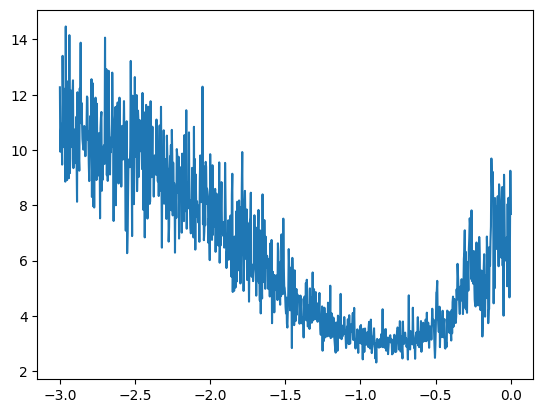

In [193]:

print(type(lri),type(lossi))
plt.plot(lri, lossi)
#plt.show()

从loss值可以看出，用该神经网络的方法可以训练出比first中更为优秀的结果？
用同样的数据训练，并用相同的数据计算loss并不能避免overfitting的产生：
将数据集分成三份：training split, dev split, validation split 8/1/1
training split:训练模型参数
dev split:训练超参数，例如隐藏层的大小，嵌入的大小，正则化参数
validation split：评估最终模型性能

In [194]:
def build_dataset(words):
    block_size = 3 #context length: how many characters do we take to predict the next one
    X,Y = [],[]  #x:INPUTS;y:LABLES
    for w in words:
        #print(w)
        context = [0]*block_size  #初始化一个长度为block_size的全零列表作为初始上下文
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  #crop and append
            #这行代码更新上下文：它去掉最旧的字符（即列表的第一个元素）并添加当前字符的新索引。这使得上下文始终包含最新的3个字符。
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
    
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [195]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [196]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator = g,requires_grad=True)
W1 = torch.randn((6,200),generator = g,requires_grad=True)  #若想要增加隐藏层神经元的个数，就可以改变W1,b1,W2100位置的数字
b1 = torch.randn(200,generator = g,requires_grad=True)
W2 = torch.randn((200,27),generator = g,requires_grad=True)
b2 = torch.randn(27,generator = g,requires_grad=True)
parameters = [C,W1,b1,W2,b2]

In [197]:
sum(p.nelement() for p in parameters) #计算总参数的多少

6881

In [206]:
lossi = []
stepi = []
for i in range(30000):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(64,))  #也可以更改batch-size(虽然size越大，可能运行速度就会越慢，但是往往结果会更好)
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)  #hidden layer output
    logits = h @ W2 + b2 #最终输出 logits
    loss = F.cross_entropy(logits,Ytr[ix])  #高效安全的函数,计算交叉熵损失，logits 是模型的预测值，Y 是真实标签。
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.01*p.grad  #learning rate一开始可以设置成0.1,再次运行之后设置成0.01
    stepi.append(i)
    lossi.append(loss.log10().item())
loss

tensor(2.6019, grad_fn=<NllLossBackward0>)

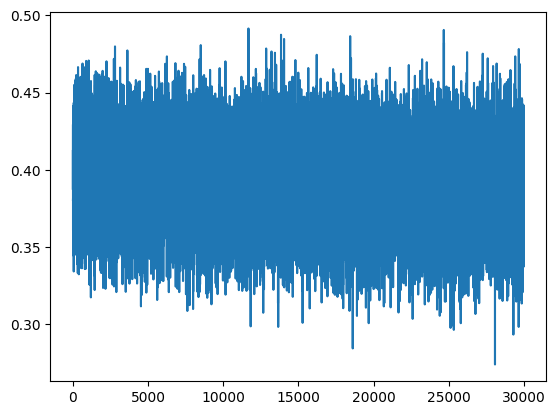

In [207]:
plt.plot(stepi,lossi)

In [208]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6)@W1 + b1)
logits = h @ W2 + b2 #最终输出 logits
loss = F.cross_entropy(logits,Ydev)
loss  #若与上面的loss差不多，说明没有达到过拟合的程度，那么需要考虑增加隐藏层神经元的个数
#若超过上面的loss，则说明可能已经过拟合了

tensor(2.4448, grad_fn=<NllLossBackward0>)

In [209]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,6)@W1 + b1)
logits = h @ W2 + b2 #最终输出 logits
loss = F.cross_entropy(logits,Yte)
loss  #用来在论文中引用时所需要的最终数据

tensor(2.4509, grad_fn=<NllLossBackward0>)

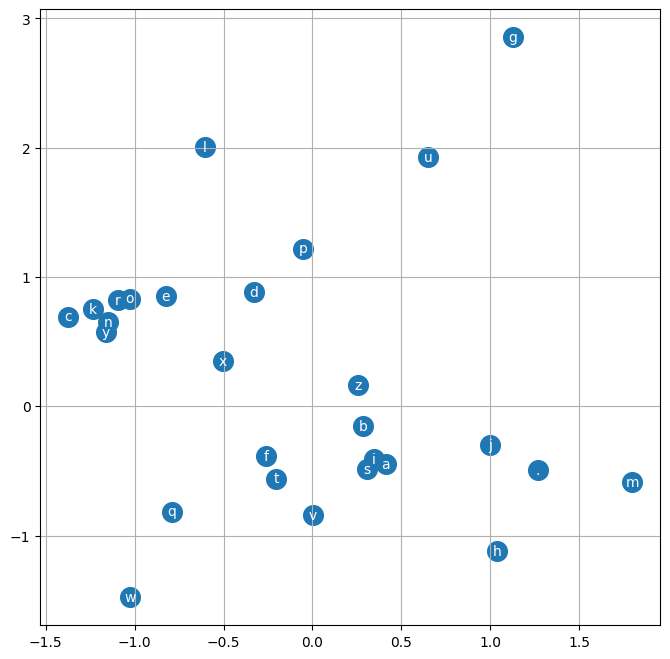

In [202]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha = "center",va = "center",color="white")
plt.grid('minor')

In [ ]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        xenc = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1)@W1 + b1)
        logits = h @ W2 + b2 #最终输出 logits
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))